In [73]:
import os
from PIL import Image
import torch
import xml.etree.ElementTree as ET
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision import models, transforms
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, BisectingKMeans
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
import matplotlib.pyplot as plt


In [74]:
#bounding box


annotation_folders = ["my_annotation_set/n02094433-Yorkshire_terrier", 
                      "my_annotation_set/n02099429-curly-coated_retriever", 
                      "my_annotation_set/n02107142-Doberman", 
                      "my_annotation_set/n02111500-Great_Pyrenees"]


def get_bounding_boxes(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bbox = []
    objects = root.findall('object')
    for obj in objects:
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        bbox.append((xmin, ymin, xmax, ymax))
    
    return bbox

for folder in annotation_folders:
    print(f"Processing folder: {folder}")
    
    for filename in os.listdir(folder):
        if filename.endswith(".xml"):
            file_path = os.path.join(folder, filename)
            bbox = get_bounding_boxes(file_path)
print("Bounding boxes created")


Processing folder: my_annotation_set/n02094433-Yorkshire_terrier
Processing folder: my_annotation_set/n02099429-curly-coated_retriever
Processing folder: my_annotation_set/n02107142-Doberman
Processing folder: my_annotation_set/n02111500-Great_Pyrenees
Bounding boxes created


In [75]:
#cropping and resizing
from pathlib import Path
image_folders = ["my_images_set/n02094433-Yorkshire_terrier", "my_images_set/n02099429-curly-coated_retriever", 
                 "my_images_set/n02107142-Doberman", "my_images_set/n02111500-Great_Pyrenees"]
output_folder = "cropped_images"

def crop_and_resize_images():
    for i, folder in enumerate(annotation_folders):
        print(f"Processing folder: {folder}")
        image_folder = image_folders[i]
        
        for filename in os.listdir(folder):
            if filename.endswith(".xml"):
                xml_file_path = os.path.join(folder, filename)
                bbox = get_bounding_boxes(xml_file_path)

                image_name = filename.replace(".xml", ".jpg")
                image_path = os.path.join(image_folder, image_name)
                
                if os.path.exists(image_path):
                    image = Image.open(image_path)

                    for idx, (xmin, ymin, xmax, ymax) in enumerate(bbox):
                        cropped_image = image.crop((xmin, ymin, xmax, ymax))
                        resized_image = cropped_image.resize((224, 224), Image.LANCZOS)

                        resized_image = resized_image.convert("RGB")

                        new_path = image_path.replace(image_folder, output_folder)
                        new_path = new_path.replace('.jpg', f'-resized.jpg')

                        head, _ = os.path.split(new_path)
                        Path(head).mkdir(parents=True, exist_ok=True)

                        resized_image.save(new_path)
    print("Saved cropped and resized images")

crop_and_resize_images()



Processing folder: my_annotation_set/n02094433-Yorkshire_terrier
Processing folder: my_annotation_set/n02099429-curly-coated_retriever
Processing folder: my_annotation_set/n02107142-Doberman
Processing folder: my_annotation_set/n02111500-Great_Pyrenees
Saved cropped and resized images


In [84]:
output_dir = 'cropped_images'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-2])
resnet18.eval()

def extract_features(directory):
    features_list = []
    labels = []

    for image_file in os.listdir(directory):
        img_path = os.path.join(directory, image_file)
        
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            try:
                img = Image.open(img_path).convert('RGB')
                img_normalized = transform(img).unsqueeze(0)  
                
                with torch.no_grad():
                    feature_map = resnet18(img_normalized)  
                    feature_map = feature_map.squeeze().cpu().numpy()  
                
                features_list.append(feature_map)

                label = image_file.split('_')[0] 
                labels.append(label)

            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    
    return np.array(features_list), np.array(labels)

features, labels = extract_features(output_dir)

print("Extracted features for each image from the last convolution layer of “ResNet18”")


c:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted features for each image from the last convolution layer of “ResNet18”


In [77]:
from sklearn.decomposition import PCA
features_reshaped = features.reshape(features.shape[0], -1)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_reshaped)
print(f"Shape of PCA-reduced features: {features_pca.shape}")

Shape of PCA-reduced features: (678, 2)


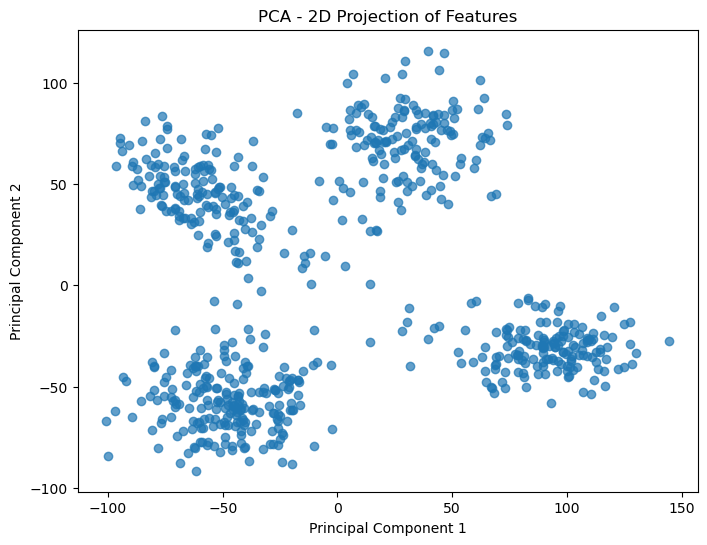

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.7)
plt.title("PCA - 2D Projection of Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [79]:
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42).fit(features_pca)
kmeans_plus = KMeans(n_clusters=4, init='k-means++', random_state=42).fit(features_pca)
bisecting_kmeans = BisectingKMeans(n_clusters=4).fit(features_pca)
spectral_clustering = SpectralClustering(n_clusters=4).fit(features_pca)
dbscan = DBSCAN(eps=0.3, min_samples=1).fit(features_pca)  

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a m

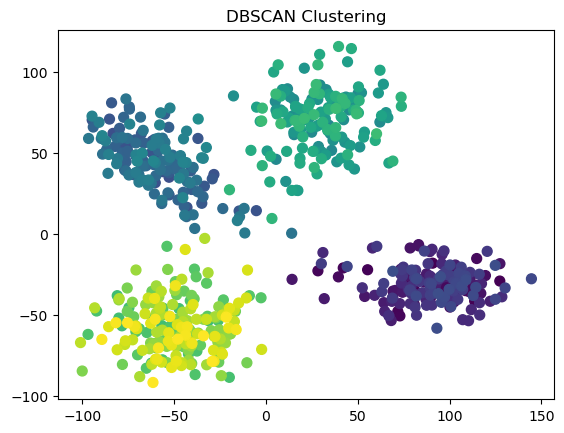

In [80]:
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan.labels_, cmap='viridis', s=50)
plt.title("DBSCAN Clustering")
plt.show()

What are the eps and min samples parameter values you used to get 4 clusters? 

eps=0.3 and the min_samples parameter=1 to get 4 clusters.

In [81]:
linkages = ['ward', 'complete', 'average', 'single']
agglomerative_labels = {}

for linkage in linkages:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=4, linkage=linkage).fit(features_pca)
    agglomerative_labels[linkage] = agglomerative_clustering.labels_

In [82]:
methods = {
    'K-means (Random)': kmeans_random.labels_,
    'K-means++': kmeans_plus.labels_,
    'Bisecting K-means': bisecting_kmeans.labels_,
    'Spectral Clustering': spectral_clustering.labels_,
    'DBSCAN': dbscan.labels_,
}

for linkage in agglomerative_labels.keys():
    methods[f'Agglomerative ({linkage})'] = agglomerative_labels[linkage]

fmi_scores = {method: fowlkes_mallows_score(labels, methods[method]) for method in methods}
silhouette_scores = {method: silhouette_score(features_pca, methods[method]) for method in methods if len(set(methods[method])) > 1}
fmi_ranked = sorted(fmi_scores.items(), key=lambda x: x[1], reverse=True)
silhouette_ranked = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)



In [83]:
import pandas as pd

fmi_df = pd.DataFrame(list(fmi_scores.items()), columns=['Method', 'Fowlkes-Mallows Index'])
fmi_df['FMI Rank'] = fmi_df['Fowlkes-Mallows Index'].rank(ascending=False, method='min')

silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=['Method', 'Silhouette Coefficient'])
silhouette_df['Silhouette Rank'] = silhouette_df['Silhouette Coefficient'].rank(ascending=False, method='min')

fmi_df = fmi_df.sort_values(by='FMI Rank').reset_index(drop=True)
silhouette_df = silhouette_df.sort_values(by='Silhouette Rank').reset_index(drop=True)

print("Fowlkes-Mallows Index Scores and Ranks")
print(fmi_df)

print("\nSilhouette Coefficient Scores and Ranks")
print(silhouette_df)


Fowlkes-Mallows Index Scores and Ranks
                     Method  Fowlkes-Mallows Index  FMI Rank
0         Bisecting K-means               0.989232       1.0
1          K-means (Random)               0.986028       2.0
2                 K-means++               0.986028       2.0
3      Agglomerative (ward)               0.974327       4.0
4   Agglomerative (average)               0.965946       5.0
5  Agglomerative (complete)               0.951415       6.0
6    Agglomerative (single)               0.792916       7.0
7       Spectral Clustering               0.503546       8.0
8                    DBSCAN               0.010944       9.0

Silhouette Coefficient Scores and Ranks
                     Method  Silhouette Coefficient  Silhouette Rank
0          K-means (Random)                0.681541              1.0
1                 K-means++                0.681541              1.0
2         Bisecting K-means                0.681268              3.0
3   Agglomerative (average)       